In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.patches as patches
import cmaps
import cartopy.feature as cfeature
from datetime import datetime,timedelta
from matplotlib.offsetbox import AnchoredText#关于修改text位置的
import cv2
from pygac import get_reader_class
import ast
from tqdm import tqdm
proj =ccrs.NorthPolarStereo(central_longitude=17.5)
from sklearn.neighbors import BallTree
from shapely.geometry import Point, Polygon,LineString
#经过实验，按经纬度插值的清晰度小于先转化为实际地理坐标系再插值的清晰度
import concurrent.futures
import pyproj
import matplotlib.style as mplstyle
from utiles import *

In [3]:
def read_AVHRR(filepath,tle_name):
    tle_dir = r'Z:\NOAA_TLE'
    reader_cls = get_reader_class(filepath)
    reader = reader_cls(tle_dir=tle_dir, tle_name=tle_name)
    reader.read(filepath)
    channels = reader.get_calibrated_channels()
    lons, lats = reader.get_lonlat()
    #根据diffs来判断overlap的扫描线序号-----------------------------------------------------------
    diffs = reader.correct_scan_line_numbers()['diffs']
    overlap_mask = (diffs==0)
    IR = channels[overlap_mask]
    lons,lats = lons[overlap_mask,:],lats[overlap_mask,:]
    #异常扫描线去除-------------------------------------------------------------------------------
    masked_scanlines = np.isnan(IR[:,:,4]).sum(axis=1)>0
    IR = IR[~masked_scanlines]
    lons = lons[~masked_scanlines,:]
    lats = lats[~masked_scanlines,:]
    return IR,lons,lats

In [4]:
def lonlat2xy(central_lon,central_lat,lons,lats):
    lons,lats = np.array(lons),np.array(lats)
    #x_distance = geodistance(central_lon,lats.flatten(),lons.flatten(),lats.flatten())，为什么不这么算
    #x1_distance = R * cos(lat1) * (lon1-central_lon)，x2_distance = R * cos(lat2) * (lon2-central_lon)
    #x1_distance-x2_distance = R * cos(lat1) * lon1+R * cos(lat2) * lon2+R*central_lon*(cos(lat1)-cos(lat2)),这使得坐标差随着central_lon的变化而变化
    #lons,lats需要是一维的
    x_distance = geodistance(central_lon,central_lat,lons.flatten(),central_lat)
    x_coords = np.where(lons.flatten()<central_lon,-x_distance,x_distance)
    y_distance = geodistance(central_lon,central_lat,central_lon,lats.flatten())
    y_coords = np.where(lats.flatten()<central_lat,-y_distance,y_distance)
    return x_coords,y_coords

In [5]:
def minmax(IR,IR_min=210,IR_max=280):
    #归一化
    IR = np.where(IR<IR_min,IR_min,IR)
    IR = np.where(IR>IR_max,IR_max,IR)
    return (IR-IR_min)/(IR_max-IR_min)

In [6]:
def deal_cloud(matched_info):
    #裁剪并重插值地表温度和AVHRR数据
    #读入AVHRR数据----------------------------------------------------------------------------
    IR,AVHRR_lons,AVHRR_lats = read_AVHRR(matched_info.filepath,matched_info.tle_name)
    central_lon,central_lat = matched_info.lon,matched_info.lat
#对地表温度和红外进行裁剪插值----------------------------------------------------------------------------------------------------------------------------
    grid_size,distance=800,2000
    #裁剪区域坐标
    points = np.concatenate([-distance*np.array(range(1,grid_size//2+1))[::-1],np.array([0]),distance*np.array(range(1,grid_size//2+1))])
    _, _,chosed_x,chosed_y = generate_rotated_grid(central_lon, central_lat,1,0,grid_size=grid_size,distance=distance)
    #ERA5数据经纬度转实际坐标
    polar_coords_xmin,polar_coords_ymin = [-802,-802]
    polar_coords_xmax,polar_coords_ymax = [802,802]
    AVHRR_x_coords,AVHRR_y_coords = lonlat2xy(central_lon,central_lat,AVHRR_lons.flatten(),AVHRR_lats.flatten())
    #减少插值范围
    AV_clip_bool  = (AVHRR_x_coords<polar_coords_xmax)& (AVHRR_x_coords>polar_coords_xmin)\
            &(AVHRR_y_coords<polar_coords_ymax)&(AVHRR_y_coords>polar_coords_ymin)
    AVHRR_coords = np.hstack([AVHRR_x_coords.reshape((-1,1)),AVHRR_y_coords.reshape((-1,1))])
    VCI_coords = np.hstack([chosed_x.reshape((-1,1)),chosed_y.reshape((-1,1))])
    trans_IR = griddata(AVHRR_coords[AV_clip_bool],IR[:,:,4].flatten()[AV_clip_bool],VCI_coords,method = 'linear').reshape((len(points),len(points)))
    nan_place = np.isnan(trans_IR)
    trans_IR255 = 255-np.uint8(minmax(trans_IR)*255)
    #根据距离远近去除模糊边缘,高于80°不要去除，会有撕裂痕
    if central_lat<80:
        tree = BallTree(AVHRR_coords, leaf_size=15)
        counts = tree.query_radius(VCI_coords, r=20, count_only=True).reshape((len(points),len(points)))
        trans_IR255[np.logical_or(nan_place,counts<1)] = 0
    trans_IR255[nan_place] = 0
    return trans_IR255[::-1]

In [7]:
ERA5_matched = pd.read_excel(r'D:\Desktop\pycode\PLs_identity\IMPMCT\example_data\matched_ERA5_tracks_2008_11.xlsx').drop(columns=['old_lon','old_lat'])#.drop(columns=['Unnamed: 0'])
ERA5_matched

,time,lon,lat,peak_value,path_index,relative,point_index,filepath,tle_name,dataset_type,satellite_name,mean_time,filename
0,2008-11-01 04:00:00,-37.25,66.00,2.193079,14,0,2,Z:\NOAA_AVHRR\NSS.GHRR.NN.D08306.S0428.E0623.B...,NOAA-18_tle.txt,GHRR,NOAA-18,2008-11-01 04:46:00,path14_2.png
1,2008-11-01 07:00:00,-34.75,65.75,2.937778,14,3,5,Z:\NOAA_AVHRR\NSS.GHRR.NL.D08306.S0650.E0844.B...,NOAA-16_tle.txt,GHRR,NOAA-16,2008-11-01 07:07:00,path14_5.png
2,2008-11-01 08:00:00,-34.75,65.75,2.486365,14,4,6,Z:\NOAA_AVHRR\NSS.GHRR.NK.D08306.S0741.E0931.B...,NOAA-15_tle.txt,GHRR,NOAA-15,2008-11-01 08:39:00,path14_6.png
3,2008-11-01 09:00:00,-34.75,65.75,2.058764,14,5,7,Z:\NOAA_AVHRR\NSS.GHRR.NL.D08306.S0839.E1030.B...,NOAA-16_tle.txt,GHRR,NOAA-16,2008-11-01 09:39:00,path14_7.png
4,2008-11-01 11:00:00,-35.00,65.75,NaN,14,999,9,Z:\NOAA_AVHRR\NSS.GHRR.M2.D08306.S1150.E1332.B...,Metop-A_tle.txt,GHRR,Metop-A,2008-11-01 11:55:00,path14_9.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8429,2008-11-30 17:00:00,-20.75,66.75,1.980021,934,0,10586,Z:\NOAA_AVHRR\NSS.GHRR.NL.D08335.S1624.E1819.B...,NOAA-16_tle.txt,GHRR,NOAA-16,2008-11-30 17:17:00,path934_10586.png
8430,2008-11-30 20:00:00,-20.25,65.75,1.747692,934,3,10589,Z:\NOAA_AVHRR\NSS.GHRR.M2.D08335.S1831.E2013.B...,Metop-A_tle.txt,GHRR,Metop-A,2008-11-30 20:10:00,path934_10589.png
8431,2008-11-30 20:00:00,-20.25,65.75,1.747692,934,3,10589,Z:\NOAA_AVHRR\NSS.GHRR.NM.D08335.S1918.E2102.B...,NOAA-17_tle.txt,GHRR,NOAA-17,2008-11-30 20:08:00,path934_10589_1.png
8432,2008-11-30 21:00:00,-20.00,65.50,1.689195,934,4,10590,Z:\NOAA_AVHRR\NSS.GHRR.M2.D08335.S2012.E2155.B...,Metop-A_tle.txt,GHRR,Metop-A,2008-11-30 21:50:00,path934_10590.png


In [ ]:
#这里举个例子,对应IMPMCT数据集的ID:405
ERA5_matched_example = ERA5_matched.loc[ERA5_matched.path_index==617]
ERA5_matched_example 

,time,lon,lat,peak_value,path_index,relative,point_index,filepath,tle_name,dataset_type,satellite_name,mean_time,filename
5350,2008-11-15 19:00:00,16.00,75.75,NaN,617,-999,6693,Z:\NOAA_AVHRR\NSS.GHRR.NM.D08320.S1825.E2010.B...,NOAA-17_tle.txt,GHRR,NOAA-17,2008-11-15 19:18:00,path617_6693.png
5351,2008-11-15 20:00:00,16.00,75.75,NaN,617,-1000,6694,Z:\NOAA_AVHRR\NSS.GHRR.M2.D08320.S1841.E2023.B...,Metop-A_tle.txt,GHRR,Metop-A,2008-11-15 20:21:00,path617_6694.png
5352,2008-11-16 00:00:00,16.25,75.50,1.992283,617,3,6698,Z:\NOAA_AVHRR\NSS.GHRR.NN.D08320.S2358.E0149.B...,NOAA-18_tle.txt,GHRR,NOAA-18,2008-11-16 00:22:00,path617_6698.png
5353,2008-11-16 02:00:00,16.00,75.50,2.221500,617,5,6700,Z:\NOAA_AVHRR\NSS.GHRR.NN.D08321.S0143.E0336.B...,NOAA-18_tle.txt,GHRR,NOAA-18,2008-11-16 02:04:00,path617_6700.png
5354,2008-11-16 03:00:00,15.75,75.50,2.234440,617,6,6701,Z:\NOAA_AVHRR\NSS.GHRR.NK.D08321.S0301.E0450.B...,NOAA-15_tle.txt,GHRR,NOAA-15,2008-11-16 03:25:00,path617_6701.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5503,2008-11-20 18:00:00,-7.00,77.25,1.656458,617,117,6812,Z:\NOAA_AVHRR\NSS.GHRR.NM.D08325.S1634.E1829.B...,NOAA-17_tle.txt,GHRR,NOAA-17,2008-11-20 18:12:00,path617_6812.png
5504,2008-11-20 19:00:00,-6.75,77.00,1.664158,617,118,6813,Z:\NOAA_AVHRR\NSS.GHRR.NM.D08325.S1824.E1954.B...,NOAA-17_tle.txt,GHRR,NOAA-17,2008-11-20 19:52:00,path617_6813.png
5505,2008-11-20 20:00:00,-6.50,76.75,1.652590,617,119,6814,Z:\NOAA_AVHRR\NSS.GHRR.NM.D08325.S1950.E2134.B...,NOAA-17_tle.txt,GHRR,NOAA-17,2008-11-20 20:43:00,path617_6814.png
5506,2008-11-20 21:00:00,-7.25,76.25,1.637281,617,120,6815,Z:\NOAA_AVHRR\NSS.GHRR.M2.D08325.S2019.E2202.B...,Metop-A_tle.txt,GHRR,Metop-A,2008-11-20 21:59:00,path617_6815.png


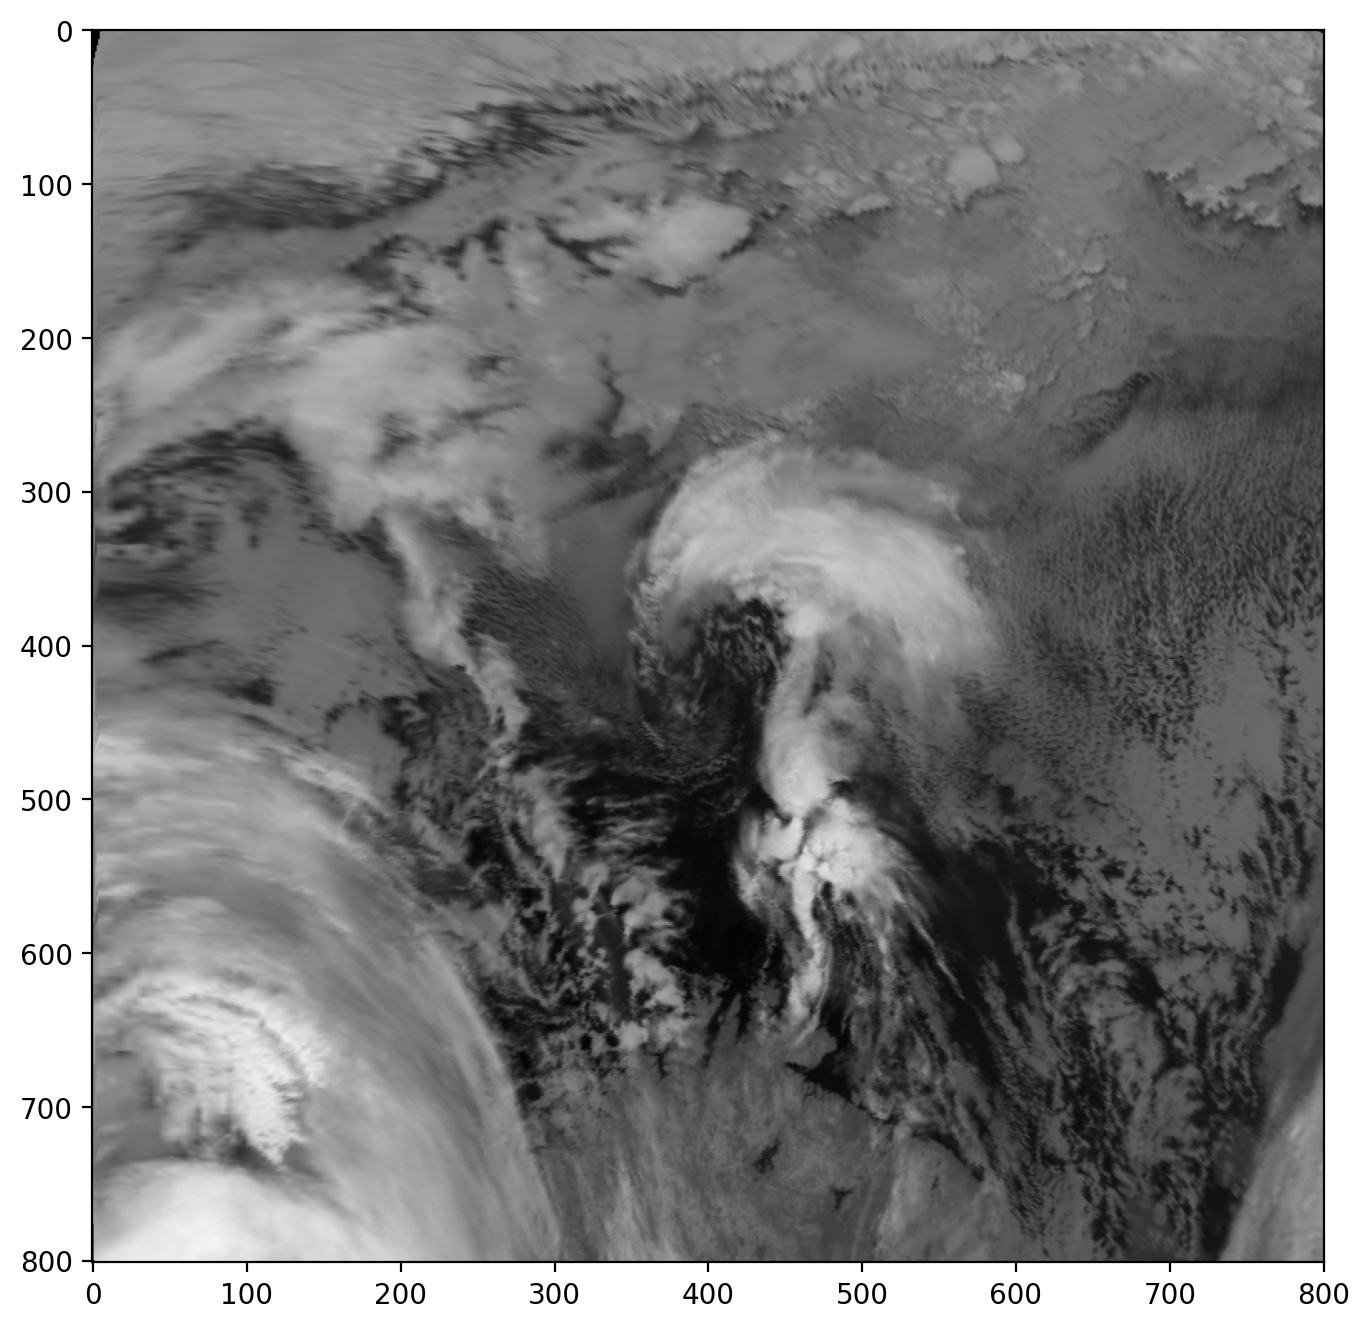

In [19]:
trans_IR255 = deal_cloud(ERA5_matched_example.iloc[47])
fig,ax = plt.subplots(1,1,figsize=(8,8),dpi=200)
ax.imshow(trans_IR255,cmap='gray',vmin=0,vmax=255)

In [21]:
for i in tqdm(range(len(ERA5_matched_example))):
        try:
            matched_info = ERA5_matched_example.iloc[i]
            save_folder = r"D:\Desktop\pycode\PLs_identity\IMPMCT\example_data\vci_examples"
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            save_path = os.path.join(save_folder,matched_info.filename)
            if os.path.exists(save_path):
                continue
            trans_IR255 = deal_cloud(matched_info)
            #写入云图
            cv2.imwrite(save_path,trans_IR255)
        except:
            continue

100%|██████████| 158/158 [12:23<00:00,  4.71s/it]
